# DownLoad ds

In [1]:
import requests 
import os
from pathlib import Path 

base_url = f"https://storage.googleapis.com/dm-meshgraphnets/cylinder_flow/"

data_folder_path = Path("dataset")
cylinder_flow_folder_path = data_folder_path/ "cylinder_flow"

os.makedirs(cylinder_flow_folder_path, exist_ok =True)

files = ["meta.json", "train.tfrecord", "valid.tfrecord", "test.tfrecord"]
for file in files: 
    file_url = base_url + file 
    out_file = os.path.join(cylinder_flow_folder_path,file)

    response = requests.get(file_url)
    
    with open(out_file, "wb") as f:
        f.write(response.content)

print("All files downloaded.")


KeyboardInterrupt: 

In [2]:
from pathlib import Path
data_folder_path = Path("dataset")
cylinder_flow_folder_path = data_folder_path/ "cylinder_flow"
os.listdir(cylinder_flow_folder_path)


['.ipynb_checkpoints', 'raw-tensor-data']

# 1. Meta 
-"mesh_pos": This is the 2D (x, y) coordinate of every node in the simulation mesh

-"node_type": This is a label for each node.

-"cells": This defines the mesh connectivity (the triangles)

-"velocity": This is the 2-component (x and y) velocity field U(x, y, t)

-"pressure": This is the scalar pressure field p(x, y, t).

-Train 1000 samples, val = test =100

# 2. Dataset

In [ ]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 

#Dataset paths
train_path = cylinder_flow_folder_path / "train.tfrecord"
test_path = cylinder_flow_folder_path / "test.tfrecord"
val_path = cylinder_flow_folder_path / "valid.tfrecord"



def parse_tf_record(sample):
    feature_description = {
            'mesh_pos': tf.io.FixedLenFeature([],dtype=tf.string),  # 
            'node_type': tf.io.FixedLenFeature([],dtype=tf.string), #  (use int64 for tf.io)
            'velocity': tf.io.FixedLenFeature([],dtype=tf.string), # 
            'pressure': tf.io.FixedLenFeature([],dtype=tf.string), # 
    }

    parsed_feature = tf.io.parse_single_example(sample, feature_description)
    features_out={} 

    features_out['mesh_pos'] = tf.io.decode_raw(parsed_feature['mesh_pos'], tf.float32)
    features_out['velocity'] = tf.io.decode_raw(parsed_feature['velocity'], tf.float32)
    features_out['pressure'] = tf.io.decode_raw(parsed_feature['pressure'], tf.float32)
    features_out['node_type'] = tf.io.decode_raw(parsed_feature['node_type'], tf.int32)
                                              
    return  features_out

def explore_data(data_path):
    dataset  = tf.data.TFRecordDataset(data_path) 
    print(f"Number of samples is: {len(list(dataset))} for the {data_path.name})")

    parsed_dataset = dataset.map(parse_tf_record)

    for i,sample in enumerate(parsed_dataset.take(1)): 
        # Get the node positions 
        mesh_pos_sparse = sample['mesh_pos']
        mesh_pos_flat = mesh_pos_sparse.numpy()
        
        # Get the velocity field 
        velocity_sparse = sample['velocity']
        velocity_flat = velocity_sparse.numpy()
        
        # Get the pressure field 
        pressure_sparse = sample['pressure']
        pressure_flat = pressure_sparse.numpy()


        #Reshape 
        mesh_pos_np = mesh_pos_flat.reshape((-1,2))
        velocity_np = velocity_flat.reshape((600,-1,2))
        pressure_np = pressure_flat.reshape((600,-1,1))

        #Attribute of 1 sample 
        num_nodes = mesh_pos_np.shape[0]
        velocity_t0 = velocity_np[0]
        pressure_t0 = pressure_np[0]
        x_coor = mesh_pos_np[:,0]
        y_coor = mesh_pos_np[:,1]
        

        print(f"\nTotal nodes in this mesh: {num_nodes}")
        print(f"Mesh position shape: {mesh_pos_np.shape}")
        
        print(f"\nFull velocity trajectory shape: {velocity_np.shape}")
        print(f"Velocity at t=0 shape: {velocity_t0.shape}")
        
        print(f"\nFull pressure trajectory shape: {pressure_np.shape}")
        print(f"Pressure at t=0 shape: {pressure_t0.shape}")

        ### ADD fig 
        fig = plt.figure(figsize =(18,7))
        fig.suptitle("CylinderFlow Dataset: Velocity Components at t=0", fontsize=16)

        #Vx_t0
        ax1 = fig.add_subplot(221,projection ="3d")
        vx_t0 =velocity_t0[:,0]
        sc1 = ax1.scatter(x_coor,y_coor,vx_t0, c=vx_t0 , cmap = "viridis",s=2)
        plt.colorbar(sc1,ax = ax1, shrink = 0.6, label = " X-Velocity (vx)",pad = 0.1)
        ax1.set_title("X-Velocity") 
        ax1.set_xlabel("X")
        ax1.set_ylabel("Y")
        ax1.set_zlabel("Vx")

        ##Vy_t0 
        ax2 = fig.add_subplot(222,projection="3d")
        vy_t0 = velocity_t0[:,1]

        sc2 = ax2.scatter(x_coor,y_coor,vy_t0, c= vy_t0, cmap = "viridis", s =2)
        plt.colorbar(sc2, ax=ax2, shrink =0.6, label = "Y-Velocity (vy)",pad =0.1)
        ax2.set_title("Y-Velocity")
        ax2.set_xlabel("X") 
        ax2.set_ylabel("Y")
        ax2.set_zlabel("Vy")

        ## pressure 
        ax3 = fig.add_subplot(223,projection="3d") 
        p_t0 = pressure_np[0]

        sc3 = ax3.scatter(x_coor,y_coor,p_t0, c=p_t0, cmap = "viridis",s=2)
        plt.colorbar(sc3,ax=ax3,shrink=0.6, label="Pressure (p)", pad =0.1) 
        ax3.set_title("Pressure") 
        ax3.set_xlabel("X") 
        ax3.set_ylabel("Y")
        ax3.set_zlabel("P")

        ## Plot
        plt.tight_layout(rect=[0,0.03,1,0.95], h_pad =3) 
        plt.show()


2025-11-16 23:06:21.633835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-11-16 17:31:56.863947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of samples 1000 in the train.tfrecord)

Total nodes in this mesh: 1876
Mesh position shape: (1876, 2)

Full velocity trajectory shape: (600, 1876, 2)
Velocity at t=0 shape: (1876, 2)

Full pressure trajectory shape: (600, 1876, 1)
Pressure at t=0 shape: (1876, 1)


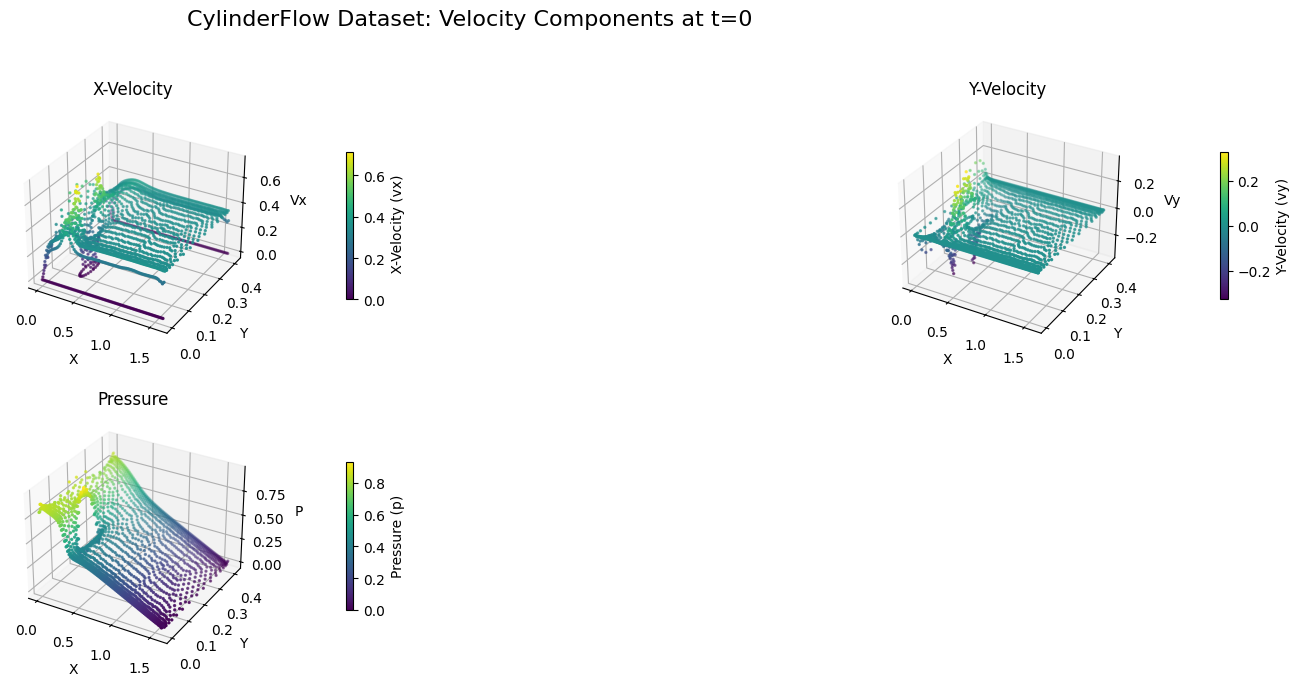

2025-11-16 17:31:58.496244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
explore_data(train_path)

2025-11-16 17:33:04.624971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of samples 100 in the valid.tfrecord)

Total nodes in this mesh: 1896
Mesh position shape: (1896, 2)

Full velocity trajectory shape: (600, 1896, 2)
Velocity at t=0 shape: (1896, 2)

Full pressure trajectory shape: (600, 1896, 1)
Pressure at t=0 shape: (1896, 1)


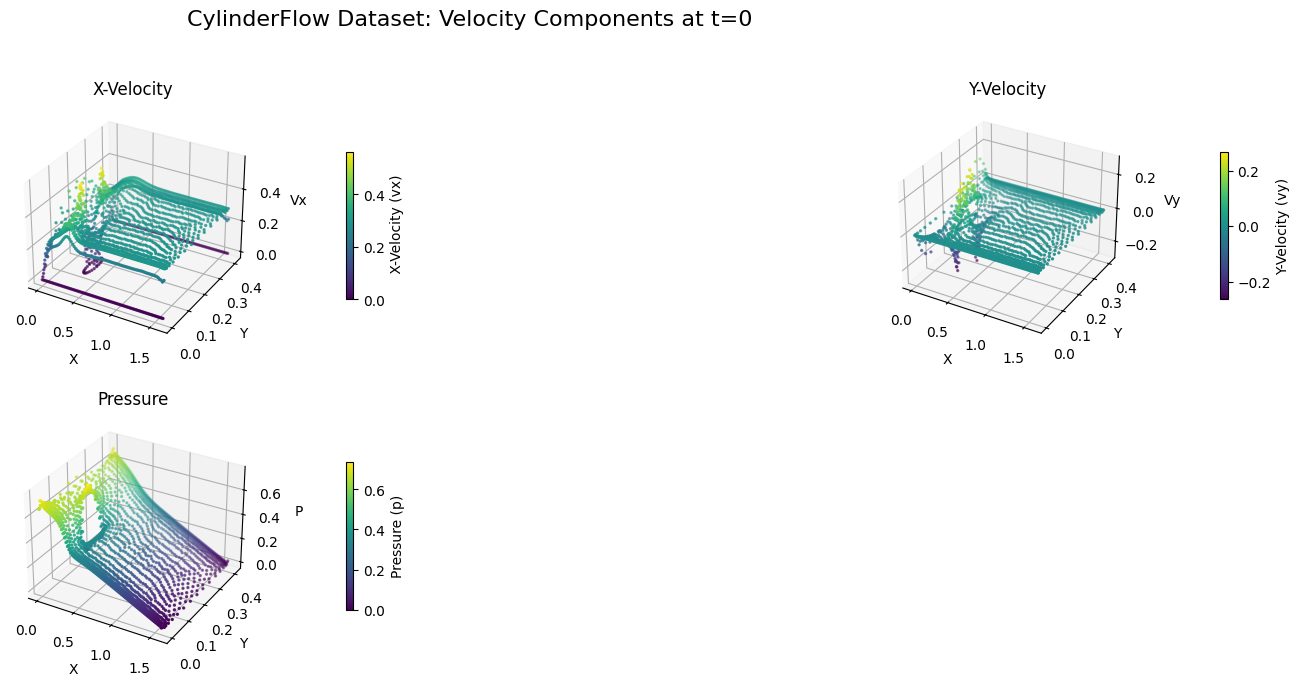

2025-11-16 17:33:05.332699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
explore_data(val_path)

2025-11-16 17:33:44.927809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of samples 100 in the test.tfrecord)

Total nodes in this mesh: 1923
Mesh position shape: (1923, 2)

Full velocity trajectory shape: (600, 1923, 2)
Velocity at t=0 shape: (1923, 2)

Full pressure trajectory shape: (600, 1923, 1)
Pressure at t=0 shape: (1923, 1)


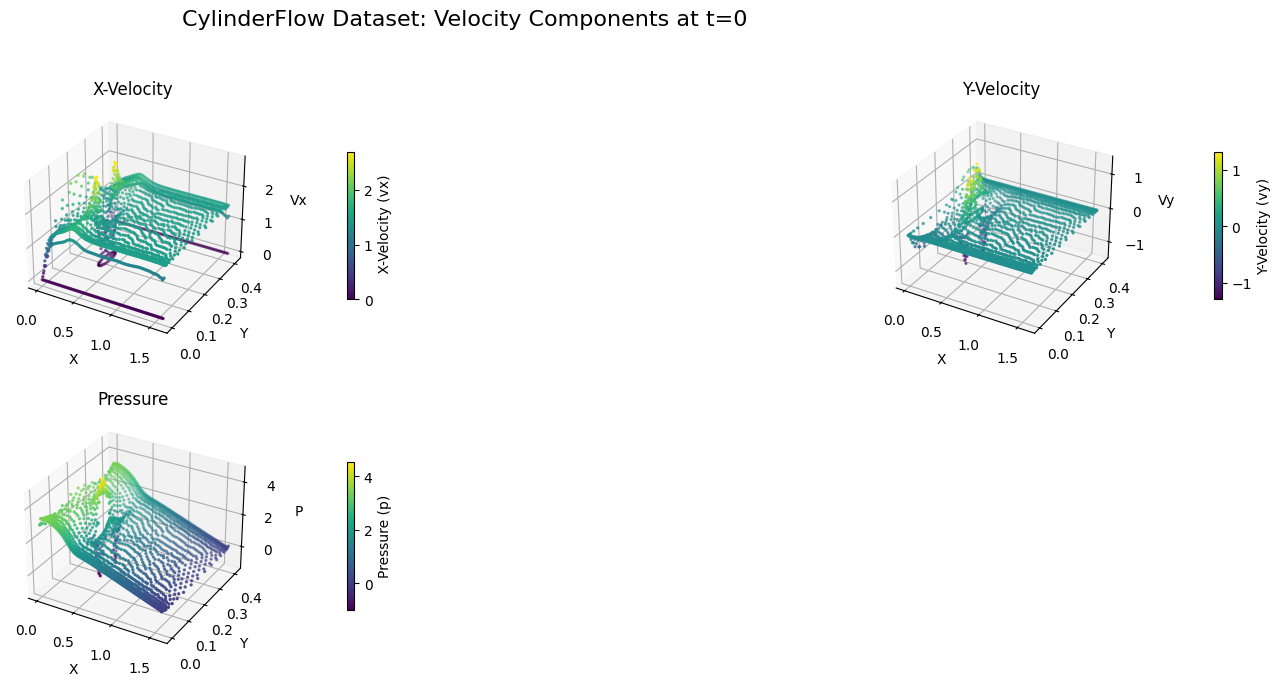

2025-11-16 17:33:45.663265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
explore_data(test_path)


## convert to h5

In [ ]:
import tensorflow as tf
import numpy as np
import h5py
import os
from tqdm import tqdm
from scipy.interpolate import griddata

# --- 1. Define the TFRecord Parsing Function ---
def parse_tfrecord_fn(example_proto):
    feature_description = {
        'mesh_pos': tf.io.FixedLenFeature([], dtype=tf.string),
        'velocity': tf.io.FixedLenFeature([], dtype=tf.string),
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    
    features_out = {}
    features_out['mesh_pos'] = tf.io.decode_raw(parsed_features['mesh_pos'], tf.float32)
    features_out['velocity'] = tf.io.decode_raw(parsed_features['velocity'], tf.float32)
    
    return features_out

# --- 2. Define Target Grid ---
# We will interpolate all data onto this regular 64x64 grid
GRID_SIZE = 64
grid_x, grid_y = np.mgrid[0:1:GRID_SIZE*1j, 0:1:GRID_SIZE*1j]
target_grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# --- 3. Main Conversion Function ---
def convert_to_hdf5_grid(base_dir, split_name, num_samples, num_timesteps):
    tfrecord_file = os.path.join(base_dir, f"{split_name}.tfrecord")
    hdf5_file = os.path.join(base_dir, f"{split_name}_grid64.h5") # New file name

    print(f"--- Processing {split_name} ---")
    print(f"Reading from: {tfrecord_file}")
    print(f"Writing to:   {hdf5_file}\n")

    dataset = tf.data.TFRecordDataset(tfrecord_file).map(parse_tfrecord_fn)
    
    with h5py.File(hdf5_file, 'w') as h5f:
        # Pre-allocate HDF5 datasets
        vel_dset = h5f.create_dataset('velocity', 
                                    shape=(num_samples, num_timesteps, GRID_SIZE, GRID_SIZE, 2), 
                                    dtype=np.float16) # Use float16 to save space

        # Loop through each simulation (1000, 100, 100)
        for idx, sample in enumerate(tqdm(dataset.take(num_samples), total=num_samples)):
            
            # --- A. Load and Reshape Unstructured Data ---
            mesh_pos_flat = sample['mesh_pos'].numpy()
            velocity_flat = sample['velocity'].numpy()
            
            num_nodes = len(mesh_pos_flat) // 2
            source_points = mesh_pos_flat.reshape((1, num_nodes, 2))[0] # Shape (e.g., 1876, 2)
            velocity_traj = velocity_flat.reshape((num_timesteps, num_nodes, 2)) # Shape (600, 1876, 2)
            
            gridded_velocity_traj = np.zeros((num_timesteps, GRID_SIZE, GRID_SIZE, 2), dtype=np.float16)

            # --- B. Loop Through Time and Interpolate ---
            for t in range(num_timesteps):
                current_velocities = velocity_traj[t] # Shape (1876, 2)
                
                # Interpolate from 1876 points to 64x64=4096 points
                gridded_frame = griddata(source_points, current_velocities, target_grid_points, 
                                         method='linear', fill_value=0.0)
                
                # Reshape from (4096, 2) to (64, 64, 2)
                gridded_velocity_traj[t] = gridded_frame.reshape((GRID_SIZE, GRID_SIZE, 2))

            # --- C. Save the *entire gridded trajectory* to HDF5 ---
            vel_dset[idx] = gridded_velocity_traj

    print(f"\nSuccessfully created {hdf5_file}\n")

# --- 4. RUN THE CONVERSION ---
if __name__ == "__main__":
    DATA_DIR = './dataset/cylinder_flow/raw-tensor-data'
    NUM_TIMESTEPS = 600
    
    SPLITS = {
        'train': 1000,
        'valid': 100,
        'test': 100
    }
    
    if not os.path.exists(os.path.join(DATA_DIR, 'meta.json')):
        print(f"Error: 'meta.json' not found in {DATA_DIR}")
    else:
        for split, num in SPLITS.items():
            convert_to_hdf5_grid(DATA_DIR, split, num, NUM_TIMESTEPS)
        
        print("--- All files converted! ---")

2025-11-17 00:42:25.277056: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 00:42:26.574851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 00:42:32.403786: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-11-17 00:42:32.403849: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: notch309
2025-11-17 00:42:32.403855: I external/loca

--- Processing train ---
Reading from: ./dataset/cylinder_flow/raw-tensor-data/train.tfrecord
Writing to:   ./dataset/cylinder_flow/raw-tensor-data/train_grid64.h5



 37%|███▋      | 373/1000 [1:50:10<3:05:04, 17.71s/it]